In [8]:
import math
import numpy as np

from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, transpile
from qiskit.providers.aer.noise import NoiseModel, depolarizing_error, pauli_error
from qiskit import Aer, execute

# from qiskit_aer import QasmSimulator
# from qiskit_aer.noise import NoiseModel, pauli_error


In [2]:
import qiskit
print(qiskit.__qiskit_version__)

{'qiskit': '0.45.0', 'qiskit-aer': '0.11.0', 'qiskit-ignis': None, 'qiskit-ibmq-provider': None, 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}


/tmp/ipykernel_26056/3443674879.py:2: DeprecationWarning: qiskit.__qiskit_version__ is deprecated since Qiskit Terra 0.25.0, and will be removed 3 months or more later. Instead, you should use qiskit.__version__. The other packages listed in theformer qiskit.__qiskit_version__ have their own __version__ module level dunder, as standard in PEP 8.
  print(qiskit.__qiskit_version__)


In [3]:
# paramters for H2 at R=1.75A
g0 = -0.5597
g1 = +0.1615
g2 = -0.0166
g3 = +0.4148
g4 = +0.1226
g5 = +0.1226
nuclear_repulsion = 0.3023869942
Energy_FCI = -0.97516853

In [4]:
p_reset = 0.1
p_meas = 0.1
p_gate1 = 0.1
p_phase = 0.1

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)
error_phase = pauli_error([('Z',p_phase), ('I', 1 - p_phase)])

# Add errors to noise model
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(error_reset, "reset")
noise_model.add_all_qubit_quantum_error(error_meas, "measure")
noise_model.add_all_qubit_quantum_error(error_gate1.compose(error_phase), ["u1", "u2", "u3"])
noise_model.add_all_qubit_quantum_error(error_gate2.compose(error_phase.tensor(error_phase)), ["cx"])

Shots:  600
Original Circuit:


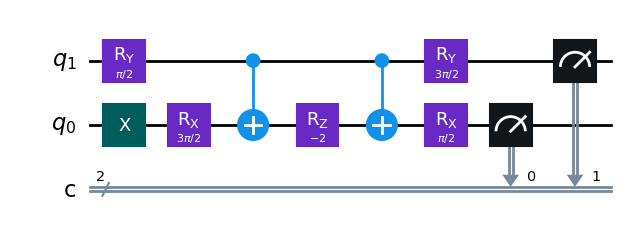

In [5]:
shots = 600
theta = [-2]
# backend = QasmSimulator(noise_model=noise_model)


print("Shots: ", shots)


# Expectation value of <Z0>, <Z1>, <Z2>
circuit = QuantumCircuit(2,2)
circuit.name = 'H2 STO-3G g1-g3'
circuit.x(0)
circuit.ry(np.pi/2,1)
circuit.rx(3*np.pi/2,0)
circuit.cx(1,0)
circuit.rz(theta[0],0)
circuit.cx(1,0)
circuit.ry(3*np.pi/2,1)
circuit.rx(np.pi/2,0)
circuit.measure(range(2), range(2))

print("Original Circuit:")
circuit.draw()

In [7]:
# # Run Circuit
# transpiled_circuit = transpile(circuit, backend)
# print("Transpiled Circuit:")
# transpiled_circuit.draw()

#### No Transpiled Circuit

In [13]:
noise_model

<NoiseModel on ['u2', 'u1', 'u3', 'reset', 'measure', 'cx']>

Result: Result(backend_name='qasm_simulator', backend_version='0.11.0', qobj_id='218eef5e-00a6-4bb8-a7d7-72764a6f385b', job_id='4727c881-e4e6-4e0f-8f14-407a9ec427c5', success=True, results=[ExperimentResult(shots=1024, success=True, meas_level=2, data=ExperimentResultData(counts={'0x1': 308, '0x2': 716}), header=QobjExperimentHeader(clbit_labels=[['c', 0], ['c', 1]], creg_sizes=[['c', 2]], global_phase=4.71238898038469, memory_slots=2, metadata={}, n_qubits=2, name='H2 STO-3G g1-g3', qreg_sizes=[['q', 2]], qubit_labels=[['q', 0], ['q', 1]]), status=DONE, seed_simulator=2556444531, metadata={'noise': 'ideal', 'batched_shots_optimization': False, 'measure_sampling': True, 'parallel_shots': 1, 'remapped_qubits': False, 'active_input_qubits': [0, 1], 'num_clbits': 2, 'parallel_state_update': 16, 'sample_measure_time': 0.000324888, 'num_qubits': 2, 'device': 'CPU', 'input_qubit_map': [[1, 1], [0, 0]], 'method': 'statevector', 'fusion': {'applied': False, 'max_fused_qubits': 5, 'threshold': 

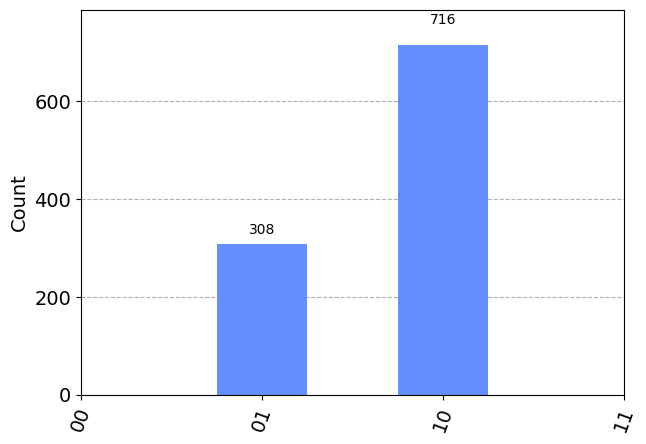

In [12]:
# job = backend.run(transpiled_circuit, shots=shots)
# job = backend.run(circuit, shots=shots)

job = execute(circuit, Aer.get_backend('qasm_simulator', noise_model=noise_model))
# job = execute(circuit, Aer.get_backend('qasm_simulator'))

result = job.result()
counts = result.get_counts(circuit)


print("Result:", result)
print("Counts:", counts)
print("Counts Keys:", counts.items())

# Probability Distribution
for k in {'00', '01', '10', '11'}:
    if k not in counts.keys():
        counts[k] = 0 # if k isn't already a key in 'counts', add k to counts with a value of 0
sorted_counts = sorted(counts.items()) # sort the items (key-value pairs) by key
print("Sorted Counts:", counts)

output_distr = [ v[1] / shots for v in sorted_counts ] # normalize
if (len(output_distr) == 1):
    output_distr.append(1-output_distr[0]) # handle single outcome case
print("Output Distribution", output_distr)

E = g0 + nuclear_repulsion
E1 = -g1 * (output_distr[0] + output_distr[1] - output_distr[2] - output_distr[3])
E2 = -g2 * (output_distr[0] - output_distr[1] + output_distr[2] - output_distr[3])
E3 = g3 * (output_distr[0] - output_distr[1] - output_distr[2] + output_distr[3])
E += E1 + E2 + E3

print("E =", E)

plot_histogram(counts)
